В рамках данного домашнего задания вам предлагается поработать как с VAE, так и с диффузионными моделями. Для выполения данного задания будем пользоваться экосистемой HuggingFace (конкретно библиотекой для работы с диффузионными моделями diffusers).

За домашнюю работу можно получить до 5 баллов.

# Подготовка окружения

In [1]:
%%capture
!pip install accelerate==1.3.0
!pip install diffusers==0.32.2
!pip install datasets==3.3.2
!pip install ipywidgets tqdm

In [2]:
import os
import cv2
from PIL import Image
from IPython.display import display

import torch
import torch.nn.functional as F
import torchvision

import numpy as np
import matplotlib.pyplot as plt

import datasets
import diffusers
import accelerate

from tqdm.notebook import tqdm

In [3]:
# device = torch.device("cuda:0")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32

# VAE & VQ-VAE (0.5 балла)

В данном задании вам будет необходимо сравнить между собой реконструкции VAE и VQ-VAE на одних и тех же входах.

Подгрузим модели, необходимые нам для работы

In [ ]:
from diffusers import AutoencoderKL, VQModel

# VAE
vae = AutoencoderKL.from_pretrained(
    "stabilityai/sd-vae-ft-mse"
).eval().to(device, dtype)

# VQ-VAE
vqvae = VQModel.from_pretrained(
    "microsoft/vq-diffusion-ithq",
    subfolder="vqvae",
).eval().to(device, dtype)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/606 [00:00<?, ?B/s]

An error occurred while trying to fetch microsoft/vq-diffusion-ithq: microsoft/vq-diffusion-ithq does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


diffusion_pytorch_model.bin:   0%|          | 0.00/256M [00:00<?, ?B/s]

Для того чтобы моделью можно было обработать входное изображение, необходимо, чтобы каждая сторона делилась нацело на 2 то количество раз, сколько в нашей модели блоков, уменьшающих разрешение в 2 раза.

In [ ]:
# Количество пикселей, на сколько должна делиться каждая сторона входного тензора в VAE
2 ** (len(vae.config.block_out_channels) - 1)

8

In [ ]:
# Количество пикселей, на сколько должна делиться каждая сторона входного тензора в VQ-VAE
2 ** (len(vqvae.config.block_out_channels) - 1)

8

In [ ]:
@torch.inference_mode()
def img2tensor(img: np.ndarray) -> torch.Tensor:
    """
    Осуществляет преобразование:
    входного numpy изображения в формате RGB, HWC, диапазон значений (0, 255)
    в выходной torch.Tensor в формате BCHW с диапазоном значений (-1, 1)
    """

    return torch.from_numpy(
        np.transpose(
            (np.asarray(img).astype(np.float32) / 127.5 - 1.0),
            (2, 0, 1)
        )[np.newaxis, ...]
    )

@torch.inference_mode()
def tensor2img(tensor: torch.Tensor) -> np.ndarray:
    """
    Осуществляет преобразование:
    входного torch.Tensor в формате BCHW с диапазоном значений (-1, 1)
    в выходной numpy array в формате BHWC с диапазоном значений (0, 255)
    """

    return (127.5 * (tensor + 1.0)).clamp(0, 255).permute(0, 2, 3, 1).cpu().to(torch.uint8).numpy()

@torch.inference_mode()
def run_vae(x: torch.Tensor, sample: bool = False) -> torch.Tensor:
    """Осуществляет кодирование и декодирование входного тензора с помощью VAE"""

    posterior = vae.encode(x.to(device, dtype)).latent_dist
    # Возьмем моду распределения, или будем осуществлять сэмплирование
    if sample:
        latent = posterior.sample()
    else:
        latent = posterior.mode()
    reconstruction = vae.decode(latent).sample
    return reconstruction

@torch.inference_mode()
def run_vqvae(x: torch.Tensor) -> torch.Tensor:
    """Осуществляет кодирование и декодирование входного тензора с помощью VQ-VAE"""

    latent = vqvae.encode(x.to(device, dtype)).latents
    reconstruction = vqvae.decode(latent).sample
    return reconstruction


def read_image(image_path: str, max_size: int = 512, divisor: int = 8):
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Image not found or cannot be read.")

    # Convert to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Get original dimensions
    height, width = image.shape[:2]

    # Determine scaling factor
    scale = max_size / max(height, width)
    new_width = int(width * scale)
    new_height = int(height * scale)

    # Ensure new dimensions are divisible by the divisor
    new_width = (new_width // divisor) * divisor
    new_height = (new_height // divisor) * divisor

    # Resize the image
    resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)

    return resized_image

## Задание 1 (сравнение VAE и VQ-VAE, 0.5 балла)

Возьмите 2-3 любых изображения с минимальной стороной >= 512 пикселей (воспользуйтесь функцией `read_image`). Осуществите сжатие и расжатие с помощью VAE и VQ-VAE и представьте результаты в виде горизонтальной конкатенации 3 изображений - оригинал, реконструкция VAE, реконструкция VQ-VAE.

Повторите данную процедуру для разных входных разрешений (параметр `max_size` в `read_image`).

Сделайте выводы, где на ваш взгляд, результаты реконструкций выглядят лучше, и как зависит качество реконструкций от входного разрешения изображений (на выводы и примеры можно не скупиться).

In [ ]:
def run_in_pipeline(image_path: str, max_size: int = 512):
    original = read_image(image_path, max_size)

    vae_res = tensor2img(
        run_vae(
            img2tensor(
                original
            )
        )
    ).squeeze()

    vqvae_res = tensor2img(
        run_vqvae(
            img2tensor(
                original
            )
        )
    ).squeeze()

    images = [original, vae_res, vqvae_res]
    titles = ['original', 'VAE', 'VQ VAE']

    fig, axes = plt.subplots(1, 3)
    fig.set_figheight(10)
    fig.set_figwidth(20)
    for i, (img, title) in enumerate(zip(images, titles)):
        axes[i].set_title(title)
        axes[i].imshow(img)

In [ ]:
IMG_PATHS = ['./corgi.jpg', './people.jpg', './simpsons.jpg']

**max_size = 512**

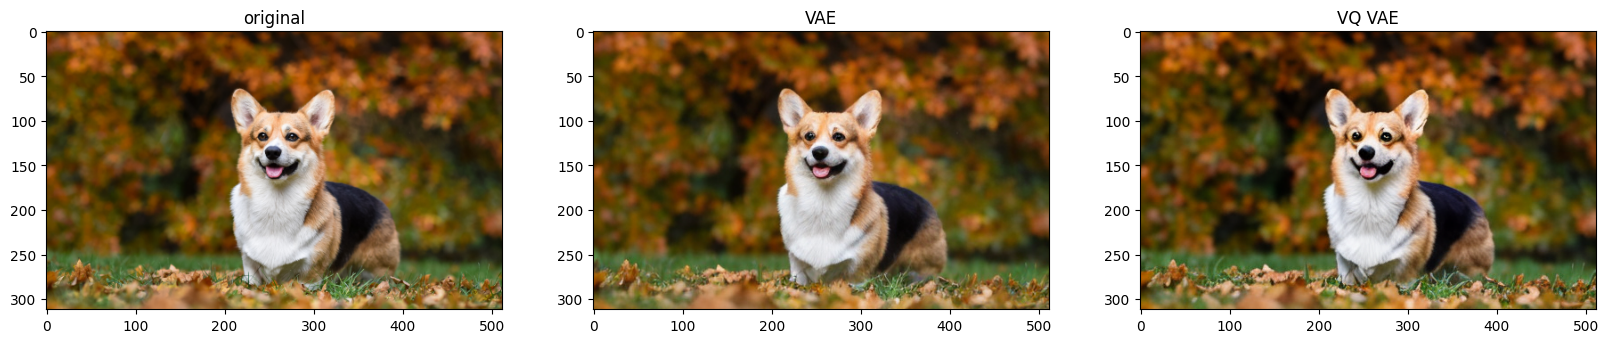

In [ ]:
run_in_pipeline(IMG_PATHS[0])

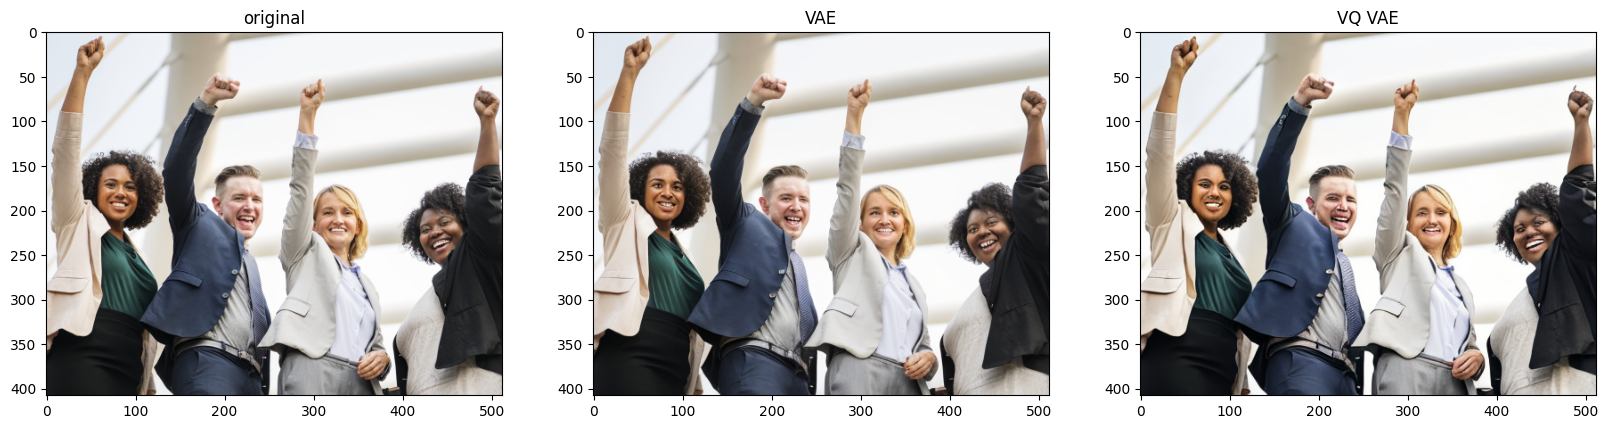

In [ ]:
run_in_pipeline(IMG_PATHS[1])

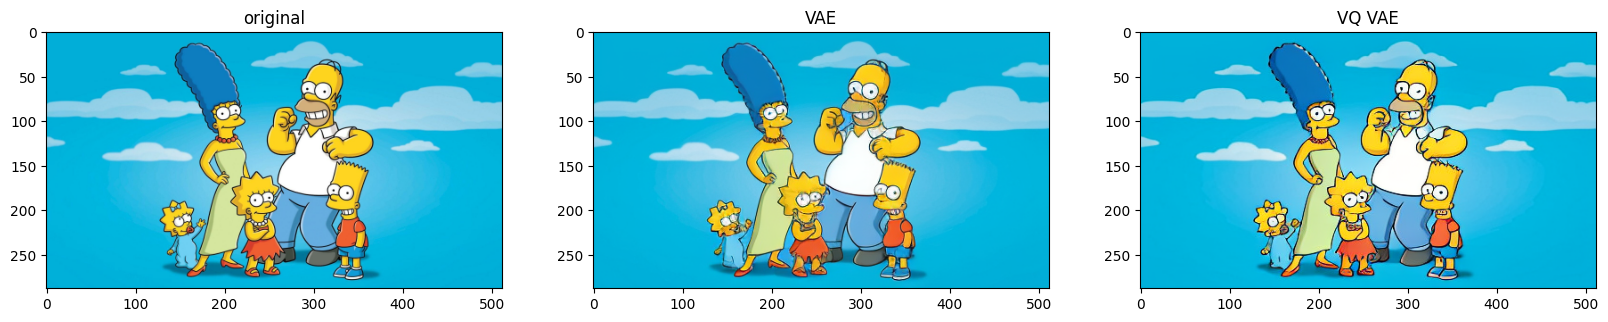

In [ ]:
run_in_pipeline(IMG_PATHS[2])

**max_size = 1024**

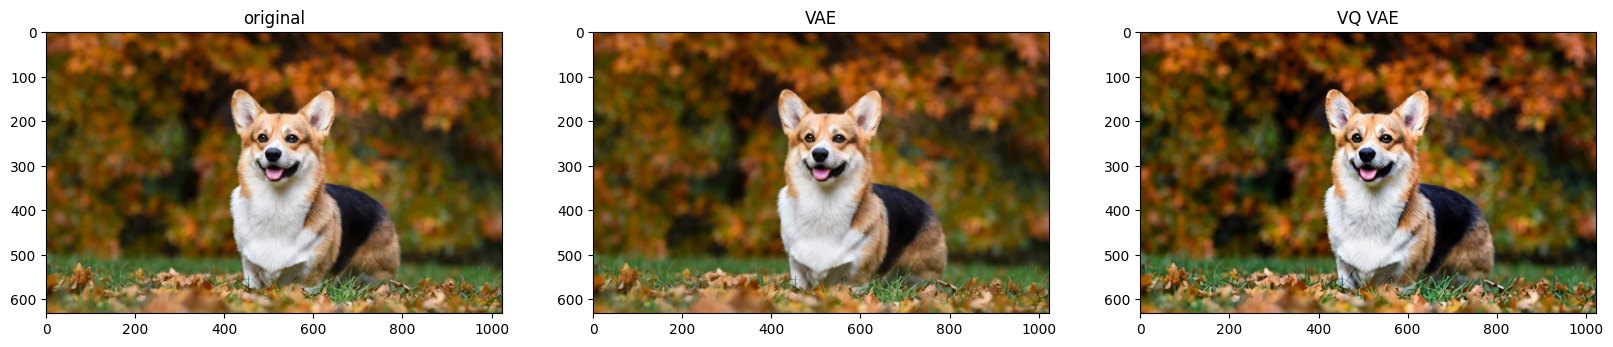

In [ ]:
run_in_pipeline(IMG_PATHS[0], max_size=1024)

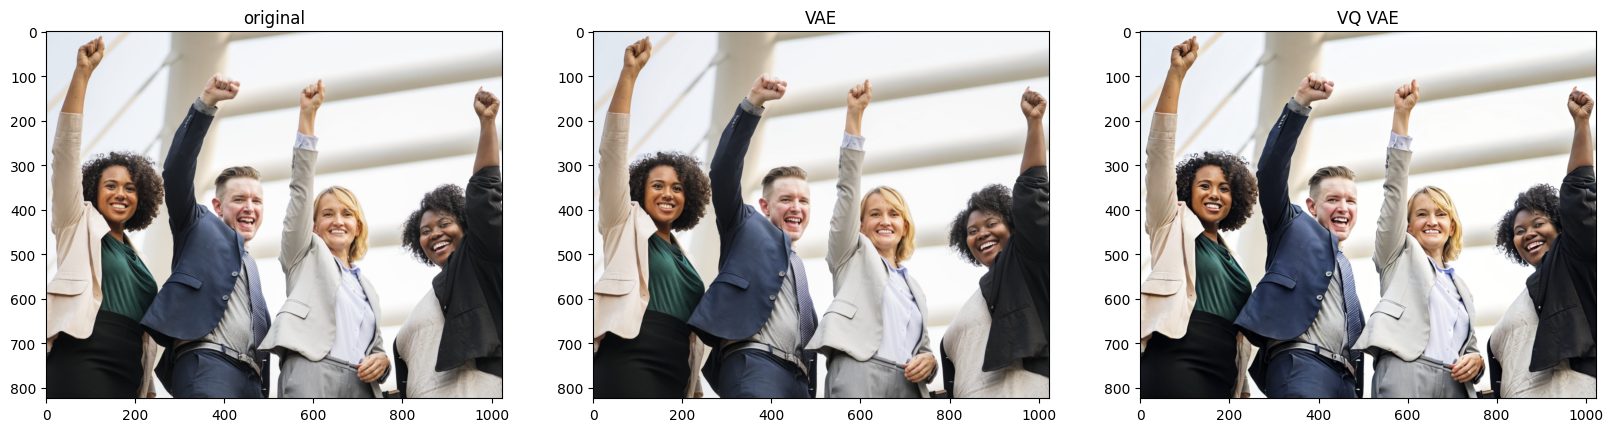

In [ ]:
run_in_pipeline(IMG_PATHS[1], max_size=1024)

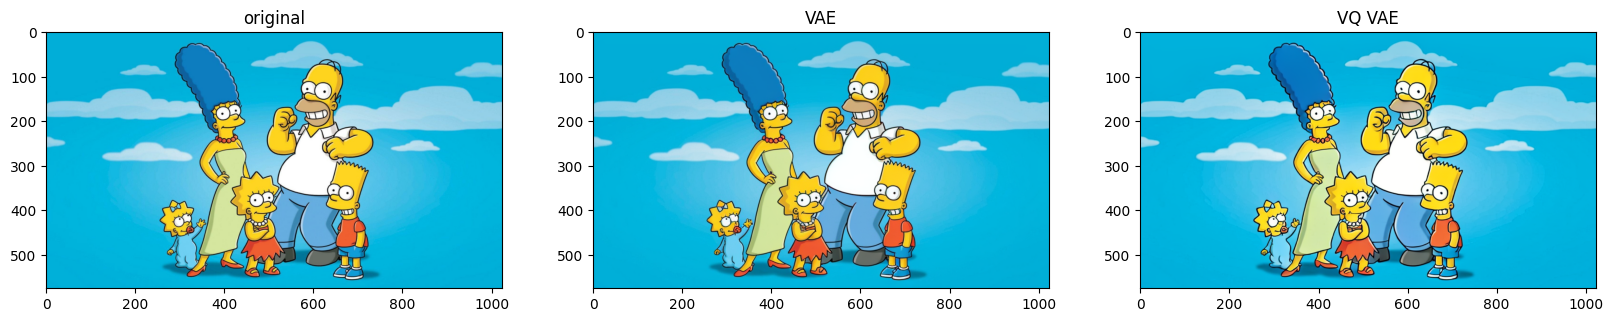

In [ ]:
run_in_pipeline(IMG_PATHS[2], max_size=1024)

**max_size = 128**

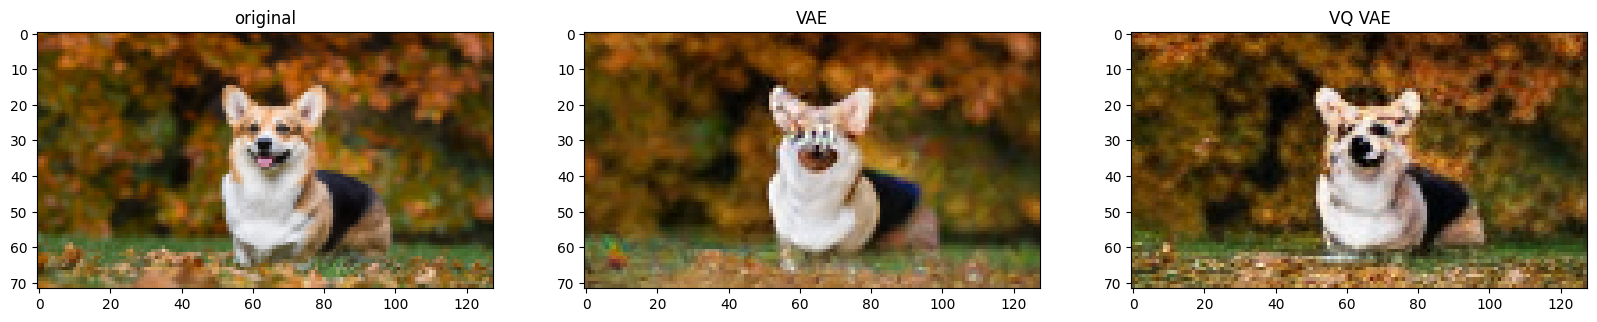

In [ ]:
run_in_pipeline(IMG_PATHS[0], max_size=128)

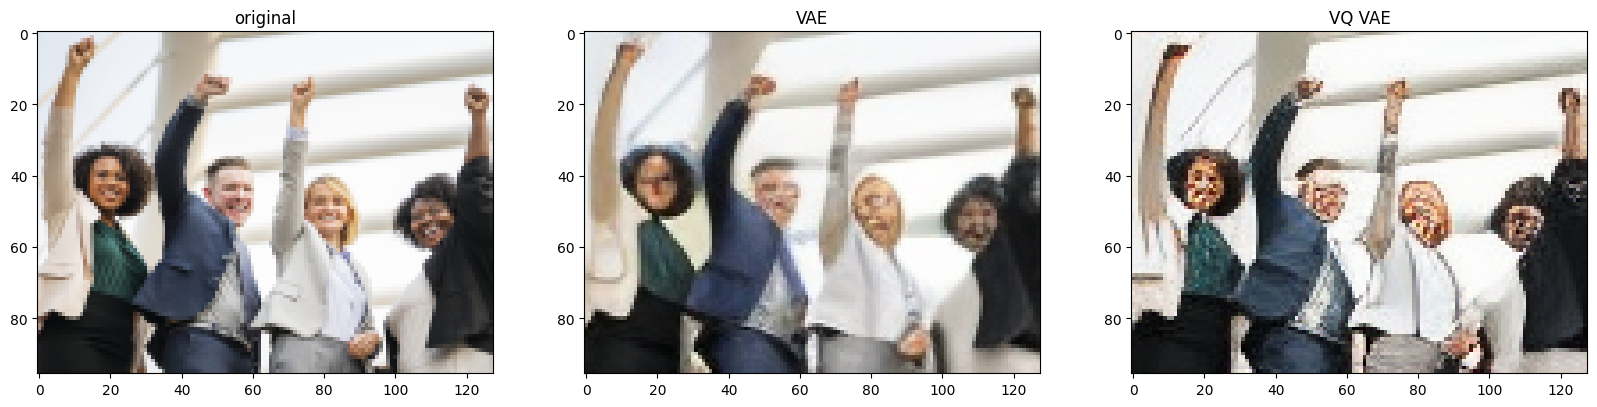

In [ ]:
run_in_pipeline(IMG_PATHS[1], max_size=128)

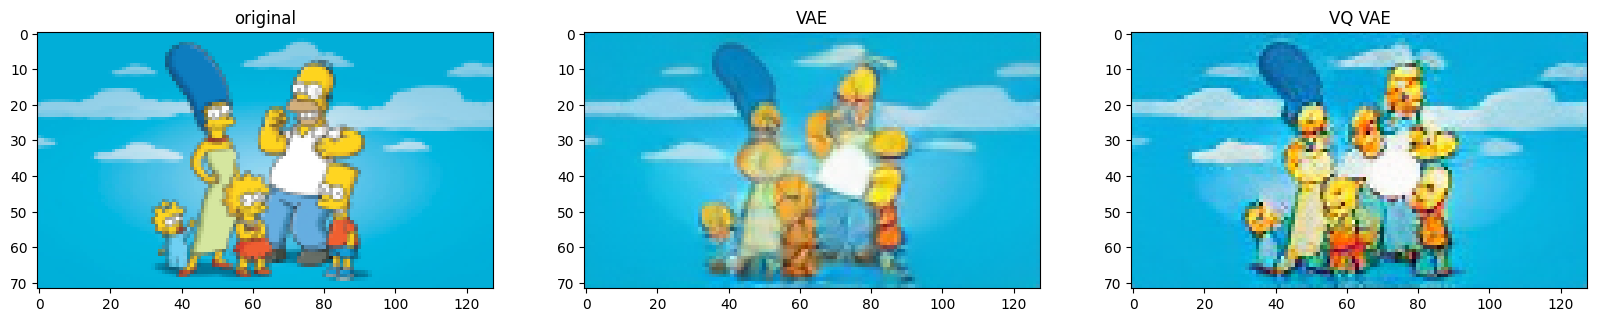

In [ ]:
run_in_pipeline(IMG_PATHS[2], max_size=128)

**Выводы**:

**1. На глаз трудно определить выглядят лучше реконструкции VAE или VQ-VAE**

> Кажется, что VAE немного получше. Может быть, дело в том, что реконструированные VAE изображения менее sharp и более soft. Это хорошо видно на фоне изображений с корги или на изображениях с меньшим разрешением.

**2. Входное разрешение сильно влияет на качество реконструкций**

> Реконструированные корги с `max_size=1024` получились похожими на настоящих.

**3. Время работы зависит от входного разрешения**

> Разрешение больше - время больше. Также VQ-VAE быстрее VAE в 2-3 раза.

**4. Возможно, на качество реконструкций влияет содержимое изображений**

> Например, размытый фон корги или чёткие границы и детали Симпсонов.

# Diffusion training & Sampling (4.5 балла)

В данном задании мы будем обучать диффузионную модель на MNIST с помощью diffusers. Обучение будет происходить в pixel space, а не в латентах VAE или VQ-VAE.

Входное разрешение MNIST - 28x28 пикселей, для простоты работы с моделью осуществим ресайз до разрешения 32x32.

Конфигурация обучения

In [4]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 32     # Resize the digits to be a power of two
    train_batch_size = 32
    eval_batch_size = 32
    num_epochs = 5
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmpup_steps = 500
    mixed_precision = 'fp16'
    seed = 0

config = TrainingConfig()

## Подготовка датасета MNIST

In [5]:
mnist_dataset = datasets.load_dataset('mnist', split='train')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/6.97k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/15.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [6]:
mnist_dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 60000
})

In [7]:
mnist_dataset[0]["image"].resize((256, 256)).show()
print("Image Size:", mnist_dataset[0]["image"].size)
print("Digit is labelled:", mnist_dataset[0]['label'])

Image Size: (28, 28)
Digit is labelled: 5


In [8]:
def transform(dataset):
    preprocess = torchvision.transforms.Compose(
        [
            torchvision.transforms.Resize(
                (config.image_size, config.image_size)),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Lambda(lambda x: 2*(x-0.5)),
        ]
    )
    images = [preprocess(image) for image in dataset["image"]]
    return {"images": images}

In [9]:
mnist_dataset.reset_format()
mnist_dataset.set_transform(transform)

In [10]:
train_dataloader = torch.utils.data.DataLoader(
    mnist_dataset,
    batch_size = config.train_batch_size,
    shuffle = True,
)

## Подготовка диффузионной модели

Будем обучать модель без условия, чтобы она генерировала нам случайную цифру.

In [13]:
from diffusers import UNet2DModel


model = UNet2DModel(
    sample_size=config.image_size,
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(128, 128, 256, 512),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

подгружаю чекпоинт модели, которую обучил ранее

In [12]:
!gdown 11k2LMmBB6uT1EYcKAvLAOXHg0XAAVdo8
!gdown 18FPDxdHYOHjXTjnPdbqnILkExfR21Tc2

Downloading...
From (original): https://drive.google.com/uc?id=11k2LMmBB6uT1EYcKAvLAOXHg0XAAVdo8
From (redirected): https://drive.google.com/uc?id=11k2LMmBB6uT1EYcKAvLAOXHg0XAAVdo8&confirm=t&uuid=84b47cf5-21cb-4945-b438-8bb6844421c6
To: /content/diffusion_pytorch_model.safetensors
100% 246M/246M [00:07<00:00, 35.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=18FPDxdHYOHjXTjnPdbqnILkExfR21Tc2
To: /content/config.json
100% 984/984 [00:00<00:00, 5.72MB/s]


In [ ]:
model = model.from_pretrained('.')
model.to(device)

Проверим, что наша модель выдает корректное выходное разрешение.

In [14]:
sample_image = mnist_dataset[0]["images"].unsqueeze(0)
print("Input shape:", sample_image.shape)

Input shape: torch.Size([1, 1, 32, 32])


In [15]:
sample_image = sample_image.to(device)
print('Output shape:', model(sample_image, timestep=0)["sample"].shape)

Output shape: torch.Size([1, 1, 32, 32])


## Расписание шума

Воспользуемся линейным расписанием шума из статьи [DDPM](https://arxiv.org/abs/2006.11239).

Поскольку наш датасет простой, снизим количество диффузионных шагов с 1000 до 200. Так процесс сэмплирования будет работать быстрее.

In [14]:
from diffusers import DDPMScheduler


noise_scheduler = diffusers.DDPMScheduler(
    num_train_timesteps=200,
    beta_schedule="linear"
)

Зашумим случайный пример

Original Digit


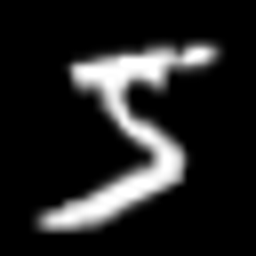

In [ ]:
print("Original Digit")
torchvision.transforms.ToPILImage()(0.5 * (sample_image.squeeze(1) + 1.0)).resize((256, 256))

Fully Noised Digit


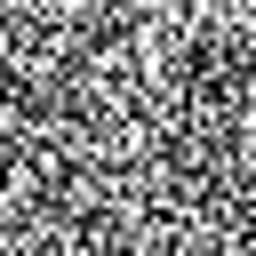

In [ ]:
sample_image = sample_image.cpu()
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([199])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

print("Fully Noised Digit")
torchvision.transforms.ToPILImage()(
    0.5 * (noisy_image.squeeze(1) + 1.0)
).resize((256, 256))

## Оптимизатор

Воспользуемся оптимизатором AdamW.

In [16]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

## Learning rate scheduler

В статье [Improved Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2102.09672) было замечено, что добавление learning rate scheduler'а, который сперва осуществляет прогрев, а затем меняет learning rate с помощью cosine scheduler делает сходимость лучше. Воспользуемся готовыми методами в diffusers

In [17]:
# Cosine learning rate scheduler

lr_scheduler = diffusers.optimization.get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmpup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

## Обучение модели

Опишем функцию, которая будет осуществлять обучение модели. Перед этим подготовим модель с помощью `accelerate`, чтобы она могла эффективно учиться в нужном нам типе данных и с потенциальной аккумуляцией градиентов между несколькими оптимизациями.

In [ ]:
def train_loop(
        config,
        model,
        noise_scheduler,
        optimizer,
        train_dataloader,
        lr_scheduler
    ):

    accelerator = accelerate.Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
    )

    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader),
                            disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch['images']

            noise = torch.randn(clean_images.shape).to(clean_images.device)
            batch_size = clean_images.shape[0]

            # Sample a set of random time steps for each image in mini-batch
            timesteps = torch.randint(
                0, noise_scheduler.num_train_timesteps, (batch_size,), device=clean_images.device
            )

            noisy_images=noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                noise_pred = model(noisy_images,timesteps)["sample"]
                loss = torch.nn.functional.mse_loss(noise_pred,noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(),1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {
                "loss" : loss.detach().item(),
                "lr" : lr_scheduler.get_last_lr()[0],
            }
            progress_bar.set_postfix(**logs)

    accelerator.unwrap_model(model)

Запустим обучение диффузионной модели (должно занимать до 20-30 минут на NVIDIA карточке).

In [ ]:
args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

accelerate.notebook_launcher(train_loop, args, num_processes=1)

Launching training on one GPU.


  0%|          | 0/1875 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

делаю чекпоинт, чтобы переиспользовать в любое время

In [ ]:
model.save_pretrained('.')

## Сэмплирование из обученной модели

Реализуем вспомогательную функцию для осуществления сэмплирования из обученной модели.

In [ ]:
@torch.no_grad()
def sample(unet, scheduler,seed,save_process_dir=None):
    torch.manual_seed(seed)

    if save_process_dir:
        if not os.path.exists(save_process_dir):
            os.mkdir(save_process_dir)

    scheduler.set_timesteps(200)
    image=torch.randn((1,1,32,32)).to(model.device)
    num_steps=max(noise_scheduler.timesteps).numpy()

    for t in tqdm(noise_scheduler.timesteps):
        model_output=unet(image,t)['sample']
        image=scheduler.step(model_output,int(t),image,generator=None)['prev_sample']
        if save_process_dir:
            save_image=torchvision.transforms.ToPILImage()(
                0.5 * (image.squeeze(0) + 1.0)
            )
            save_image.resize((256,256)).save(
                os.path.join(save_process_dir,"seed-"+str(seed)+"_"+f"{num_steps-t.numpy():03d}"+".png"),format="png")

    return torchvision.transforms.ToPILImage()(
        0.5 * (image.squeeze(0) + 1.0)
    )

Видим, что не все генерации похожи на цифры.

  0%|          | 0/200 [00:00<?, ?it/s]

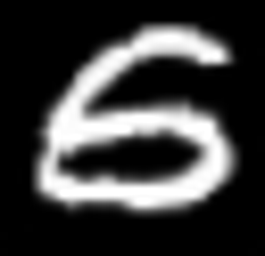

In [ ]:
test_image=sample(model,noise_scheduler,2)
test_image.resize((265,256))

Но при этом присутствуют и хорошие генерации.

  0%|          | 0/200 [00:00<?, ?it/s]

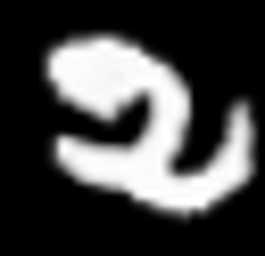

In [ ]:
test_image=sample(model,noise_scheduler,42)
test_image.resize((265,256))

  0%|          | 0/200 [00:00<?, ?it/s]

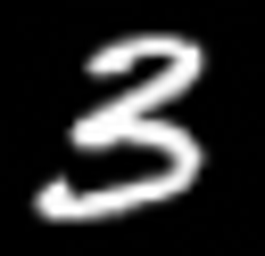

In [ ]:
test_image=sample(model,noise_scheduler,1991)
test_image.resize((265,256))

## Задание 2 (inpainting без переобучения модели, 1.5 балла)

Скопируйте и модифицируйте функцию, осуществляющую сэмплирование из обученной диффузионной модели выше. Модифицируйте ее таким образом, чтобы она решала задачу inpainting (восстанавливала замаскированную часть входного изображения).

Новая функция сэмплирования должна дополнительно принимать замаскированный пример и бинарную маску. Для простоты сконструируйте 4 маски, закрывающие верхнюю, нижнюю, левую и правую часть входного примера.

Продемонстрируйте результаты генерации для 3-4 входных примеров и 3-4 разных входных сидов.
Оцените, как работает модель на одних и тех же входных примерах, но разных сидах, сделайте выводы.

In [ ]:
def create_masks(image_size):
    """
    Создаёт маски для inpainting
    """
    masks = []
    top = torch.zeros((1, 1, image_size, image_size))
    top[:, :, :image_size // 2, :] = 1
    masks.append(top)

    bottom = torch.zeros((1, 1, image_size, image_size))
    bottom[:, :, image_size // 2:, :] = 1
    masks.append(bottom)

    left = torch.zeros((1, 1, image_size, image_size))
    left[:, :, :, :image_size // 2] = 1
    masks.append(left)

    right = torch.zeros((1, 1, image_size, image_size))
    right[:, :, :, image_size // 2:] = 1
    masks.append(right)

    return masks

In [ ]:
# к четырём примерам применяются четыре маски
# masked_images = [image_1 x mask_1, image_1 x mask_2, image_1 x mask_3, image_1 x mask_4, image_2 x mask_1, ...]

images = [torch.randn(1, 1, 32, 32) for _ in range(4)]
example_images = 4 * [images[0]] + 4 * [images[1]] + 4 * [images[2]] + 4 * [images[3]]

masks = create_masks(image_size=32) * 4

assert len(example_images) == len(masks)
assert torch.equal(masks[0], masks[4])
assert torch.equal(example_images[0], example_images[1])

masked_images = [example_images[i] * masks[i] for i in range(len(masks))]

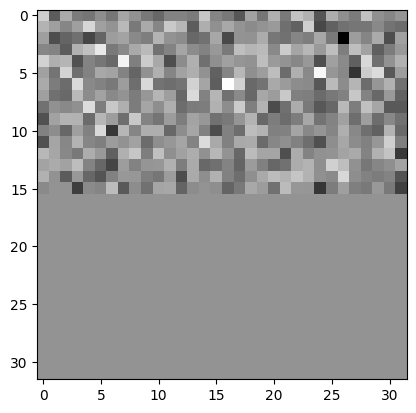

In [ ]:
plt.imshow(masked_images[0].squeeze(), cmap='gray')

In [ ]:
@torch.no_grad()
def sample_inpainting(unet, scheduler, masked_image, mask, seed, save_process_dir=None):
    torch.manual_seed(seed)
    if save_process_dir:
        if not os.path.exists(save_process_dir):
            os.mkdir(save_process_dir)

    scheduler.set_timesteps(200)

    masked_image = masked_image.to(unet.device)
    mask = mask.to(unet.device)
    image = torch.randn_like(masked_image).to(unet.device)

    num_steps = max(noise_scheduler.timesteps).item()

    for t in tqdm(scheduler.timesteps):
        noisy_input = image * (1 - mask) + masked_image * mask

        model_output = unet(noisy_input, t)['sample']
        image = scheduler.step(model_output, int(t), image, generator=None)['prev_sample']

        if save_process_dir:
            save_image = torchvision.transforms.ToPILImage()(
                0.5 * (image.squeeze(0) + 1.0)
            )
            save_image.resize((256, 256)).save(
                os.path.join(
                    save_process_dir,
                    f"seed-{seed}_step-{num_steps - t.item():03d}.png"
                ),
                format="PNG"
            )

    return torchvision.transforms.ToPILImage()(
        0.5 * (image.squeeze(0) + 1.0)
    )

In [ ]:
def concat_images(images, width, height):
    concat_img = Image.new('L', (width, height))

    for i in range(len(images)):
        img = images[i].resize((width // 4, height))
        concat_img.paste(img, ((width // 4) * i, 0))

    plt.imshow(concat_img, cmap='gray')

**seed = 2**

In [ ]:
results = []

for masked_image, mask in zip(masked_images, masks):
    result_image = sample_inpainting(model, noise_scheduler, masked_image, mask, 2)
    results.append(result_image)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

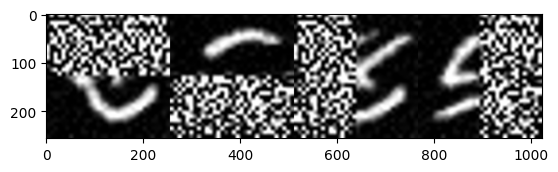

In [ ]:
concat_images(results[:4], width=1024, height=256)

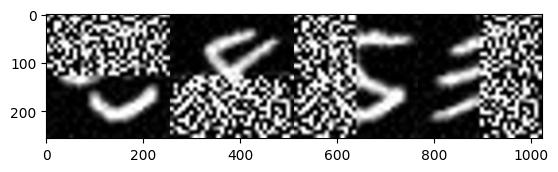

In [ ]:
concat_images(results[4:8], width=1024, height=256)

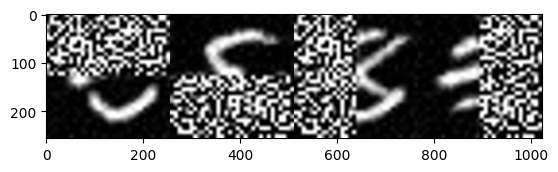

In [ ]:
concat_images(results[8:12], width=1024, height=256)

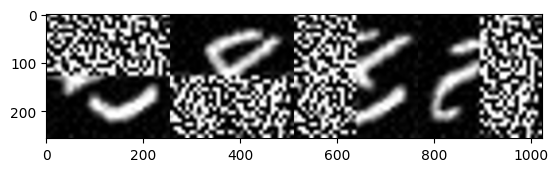

In [ ]:
concat_images(results[12:], width=1024, height=256)

**seed=42**

In [ ]:
results = []

for masked_image, mask in zip(masked_images, masks):
    result_image = sample_inpainting(model, noise_scheduler, masked_image, mask, 42)
    results.append(result_image)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

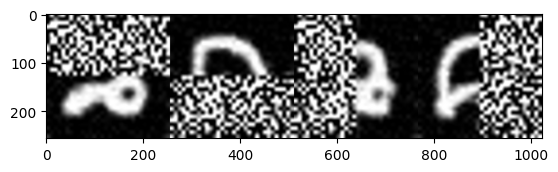

In [ ]:
concat_images(results[:4], width=1024, height=256)

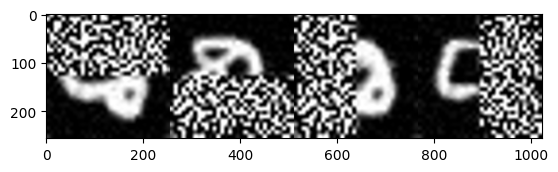

In [ ]:
concat_images(results[4:8], width=1024, height=256)

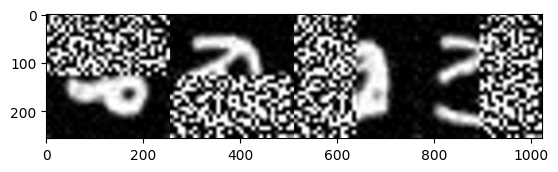

In [ ]:
concat_images(results[8:12], width=1024, height=256)

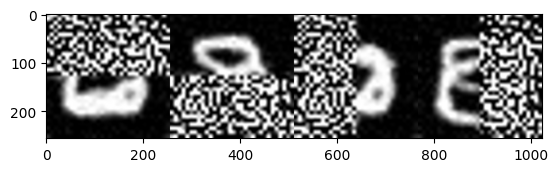

In [ ]:
concat_images(results[12:], width=1024, height=256)

**seed=1991**

In [ ]:
results = []

for masked_image, mask in zip(masked_images, masks):
    result_image = sample_inpainting(model, noise_scheduler, masked_image, mask, 1991)
    results.append(result_image)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

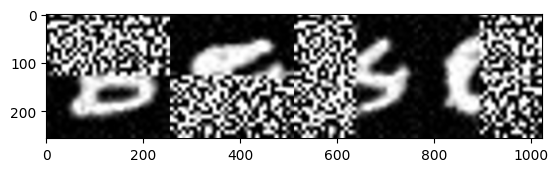

In [ ]:
concat_images(results[:4], width=1024, height=256)

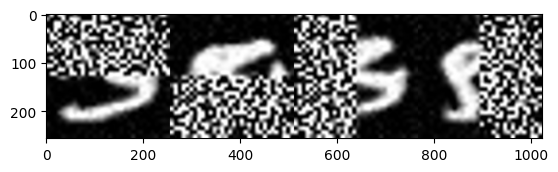

In [ ]:
concat_images(results[4:8], width=1024, height=256)

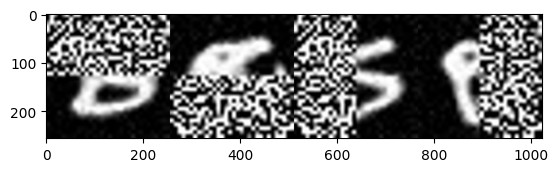

In [ ]:
concat_images(results[8:12], width=1024, height=256)

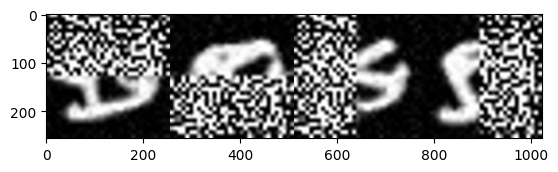

In [ ]:
concat_images(results[12:], width=1024, height=256)

**Вывод**:

- `seed=2`

Пытается предсказать что-то похожее на 3, 5 или 8. Наверное, из-за дуги снизу в написании цифры. Более тонкое написание по сравнению с другими сидами

- `seed=42`

Пытается предсказать что-то похожее на 3, 8 или 9. Цифры менее крупные

- `seed=1991`

Меньше всего похоже на цифры

## Задание 3 (inpainting с переобучением модели, 3 балла)

Скопируйте и модифицируйте код обучения диффузионной модели выше таким образом, чтобы вы обучали диффузионную модель специально для inpainting.

Для этого модель теперь должна принимать 6 каналов (3 канала для текущего зашумленного изображения, 3 канала для замаскированного примера, 1 канал для маски), в модель необходимо подавать конкатенацию всех трех тензоров по размерности каналов. Как и раньше, модель должна выдавать предсказанный шум.

Для простоты переиспользуйте 4 маски из задания 1 (маски, закрывающие верхнюю, нижнюю, левую и правую части изображения).

При обучении в 1 батч данных лучше подавать разные маски, чтобы на каждой итерации модель училась работать с разными масками.

Напишите соответствующую данной модели функцию сэмплирования и продемонстрируйте ее работу на 3-4 входных примерах и 3-4 разных входных сидов. Оцените, как работает модель на одних и тех же входных примерах, но на разных сидах. Сравните, насколько данная модель лучше справляется с задачей inpainting по сравнению с подходом из задания 1.

In [26]:
from diffusers import UNet2DModel


model = UNet2DModel(
    sample_size=config.image_size,
    in_channels=1+1+1,  # noised_image + masked_image + mask
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(128, 128, 256, 512),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

In [27]:
from diffusers import DDPMScheduler


noise_scheduler = diffusers.DDPMScheduler(
    num_train_timesteps=200,
    beta_schedule="linear"
)

In [28]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

lr_scheduler = diffusers.optimization.get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmpup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

In [29]:
def create_masks(image_size):
    """
    Создаёт маски для inpainting
    """
    masks = []
    top = torch.zeros((1, 1, image_size, image_size))
    top[:, :, :image_size // 2, :] = 1
    masks.append(top)

    bottom = torch.zeros((1, 1, image_size, image_size))
    bottom[:, :, image_size // 2:, :] = 1
    masks.append(bottom)

    left = torch.zeros((1, 1, image_size, image_size))
    left[:, :, :, :image_size // 2] = 1
    masks.append(left)

    right = torch.zeros((1, 1, image_size, image_size))
    right[:, :, :, image_size // 2:] = 1
    masks.append(right)

    return masks

In [30]:
def train_loop_impainting(
        config,
        model,
        noise_scheduler,
        optimizer,
        train_dataloader,
        lr_scheduler
):

    accelerator = accelerate.Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
    )

    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    # создаём маски
    masks = create_masks(config.image_size)

    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader),
                            disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch['images']

            noise = torch.randn(clean_images.shape).to(clean_images.device)
            batch_size = clean_images.shape[0]

            # batch_size рандомных маск
            random_masks = [
                masks[torch.randint(0, len(masks), (1,)).item()] for _ in range(batch_size)
            ]

            # конкатенируем в тензор [32, 1, 32, 32]
            random_masks = torch.cat(random_masks, dim=0).to(clean_images.device)

            # применяем маски к изображениям
            masked_images = clean_images * random_masks

            # Sample a set of random time steps for each image in mini-batch
            timesteps = torch.randint(
                0, noise_scheduler.num_train_timesteps, (batch_size,), device=clean_images.device
            )

            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            # конкатенируем поканально
            input = torch.cat([noisy_images, masked_images, random_masks], dim=1)

            with accelerator.accumulate(model):
                noise_pred = model(input, timesteps)["sample"]
                loss = torch.nn.functional.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {
                "loss" : loss.detach().item(),
                "lr" : lr_scheduler.get_last_lr()[0],
            }
            progress_bar.set_postfix(**logs)

    accelerator.unwrap_model(model)

In [31]:
args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

accelerate.notebook_launcher(train_loop_impainting, args, num_processes=1)

Launching training on one GPU.


  0%|          | 0/1875 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

In [32]:
model.save_pretrained('.')

In [60]:
@torch.no_grad()
def inpaint_sample(unet, scheduler, masked_image, mask, seed, save_process_dir=None):
    torch.manual_seed(seed)
    if save_process_dir:
        if not os.path.exists(save_process_dir):
            os.mkdir(save_process_dir)

    scheduler.set_timesteps(200)

    masked_image = masked_image.to(unet.device)
    mask = mask.to(unet.device)
    image = torch.randn_like(masked_image).to(unet.device)

    num_steps = max(noise_scheduler.timesteps).item()

    for t in tqdm(scheduler.timesteps):

        input = torch.cat([image, masked_image, mask], dim=1)
        output = unet(input, t)['sample']
        image = scheduler.step(output, int(t), image, generator=None)['prev_sample']

        if save_process_dir:
            save_image = torchvision.transforms.ToPILImage()(
                0.5 * (image.squeeze(0) + 1.0)
            )
            save_image.resize((256, 256)).save(
                os.path.join(
                    save_process_dir,
                    f"seed-{seed}_step-{num_steps - t.item():03d}.png"
                ),
                format="PNG"
            )

    return torchvision.transforms.ToPILImage()(
        0.5 * (image.squeeze(0) + 1.0)
    )

In [45]:
def concat_images(images, width, height):
    concat_img = Image.new('L', (width, height))

    for i in range(len(images)):
        img = images[i].resize((width // 4, height))
        concat_img.paste(img, ((width // 4) * i, 0))

    plt.imshow(concat_img, cmap='gray')

In [46]:
# к четырём примерам применяются четыре маски
# masked_images = [image_1 x mask_1, image_1 x mask_2, image_1 x mask_3, image_1 x mask_4, image_2 x mask_1, ...]

images = [torch.randn(1, 1, 32, 32) for _ in range(4)]
example_images = 4 * [images[0]] + 4 * [images[1]] + 4 * [images[2]] + 4 * [images[3]]

masks = create_masks(image_size=32) * 4

assert len(example_images) == len(masks)
assert torch.equal(masks[0], masks[4])
assert torch.equal(example_images[0], example_images[1])

masked_images = [example_images[i] * masks[i] for i in range(len(masks))]

**seed = 2**

In [48]:
results = []

for masked_image, mask in zip(masked_images, masks):
    result_image = inpaint_sample(model, noise_scheduler, masked_image, mask, 2)
    results.append(result_image)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

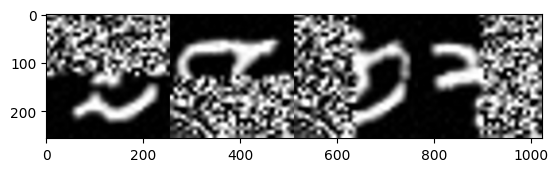

In [49]:
concat_images(results[:4], width=1024, height=256)

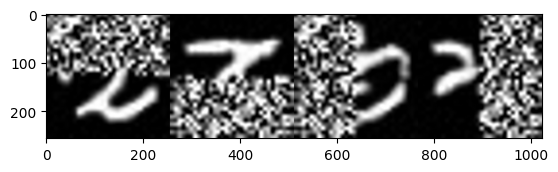

In [50]:
concat_images(results[4:8], width=1024, height=256)

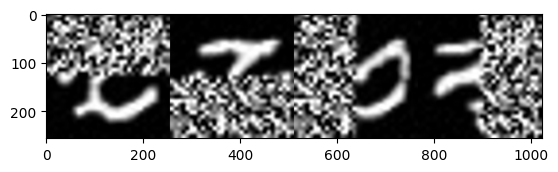

In [51]:
concat_images(results[8:12], width=1024, height=256)

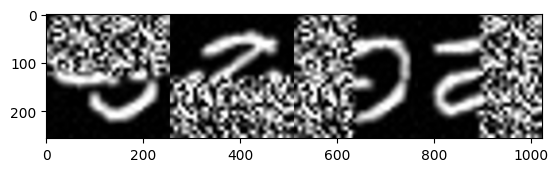

In [52]:
concat_images(results[12:], width=1024, height=256)

**seed=42**

In [54]:
results = []

for masked_image, mask in zip(masked_images, masks):
    result_image = inpaint_sample(model, noise_scheduler, masked_image, mask, 42)
    results.append(result_image)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

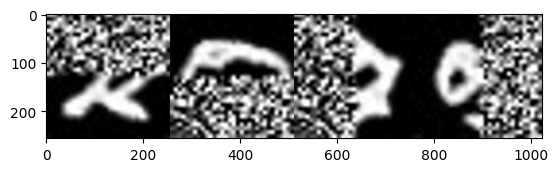

In [55]:
concat_images(results[:4], width=1024, height=256)

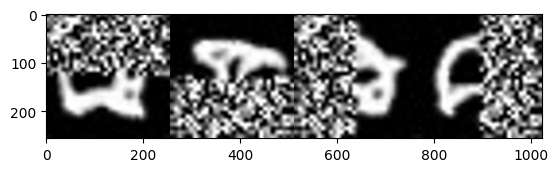

In [56]:
concat_images(results[4:8], width=1024, height=256)

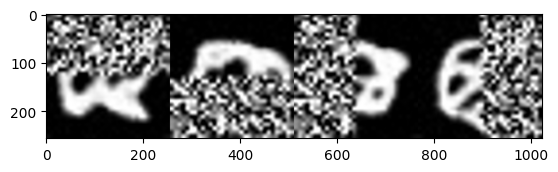

In [57]:
concat_images(results[8:12], width=1024, height=256)

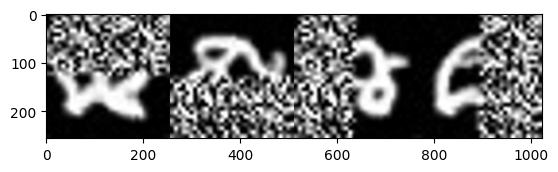

In [58]:
concat_images(results[12:], width=1024, height=256)

**seed=1991**

In [61]:
results = []

for masked_image, mask in zip(masked_images, masks):
    result_image = inpaint_sample(model, noise_scheduler, masked_image, mask, 1991)
    results.append(result_image)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

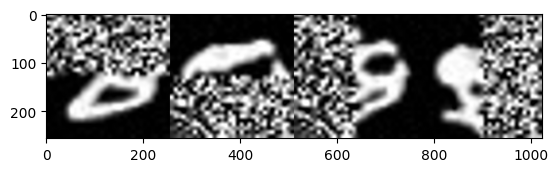

In [62]:
concat_images(results[:4], width=1024, height=256)

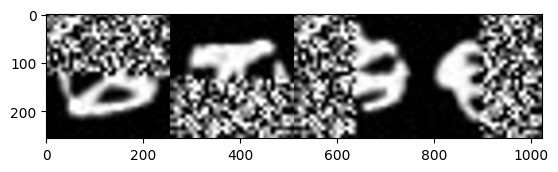

In [63]:
concat_images(results[4:8], width=1024, height=256)

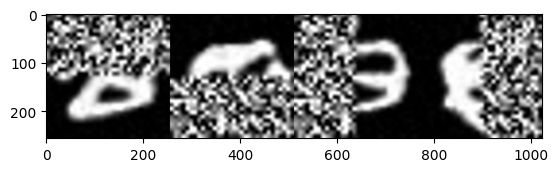

In [64]:
concat_images(results[8:12], width=1024, height=256)

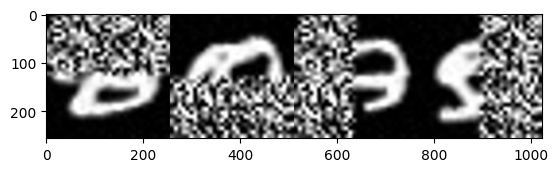

In [65]:
concat_images(results[12:], width=1024, height=256)

**Выводы**:

- честно говоря, мне кажется, что во всех заданиях с `inpainting`-ами результаты получились не очень
- может быть, потому что в заданиях 2 и 3 я неправильно написал семплирование и обучение, но, вроде, работает
- буду рад, если оставите обратную связь